# Data Wrangling and EDA

In [1]:
!conda run -n nutrisage-eda python -c "import sys, os; print(sys.executable); print(os.environ['CONDA_DEFAULT_ENV'])"

/home/sagemaker-user/.conda/envs/nutrisage-eda/bin/python
nutrisage-eda



In [2]:
from IPython.display import display

### 1. Quick Smoke Test

In [3]:
from pyathena import connect

conn = connect(s3_staging_dir = "s3://nutrisage-athena-results-352364310453/athena-tmp/",
                region_name = "us-east-1")

In [4]:
import pandas as pd

df = pd.read_sql("SELECT count(*) AS rows FROM nutrisage_datalake.processed", conn)
display(df)

/tmp/ipykernel_7368/3150741353.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT count(*) AS rows FROM nutrisage_datalake.processed", conn)


,rows
0,3796056


### 2. Automated Data Profiling

In [5]:
sample_df = pd.read_sql("""
    SELECT *
    FROM nutrisage_datalake.processed
    TABLESAMPLE BERNOULLI (10)
    """, conn)

/tmp/ipykernel_7368/2060585798.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_df = pd.read_sql("""


In [6]:
display(sample_df.shape)

(379409, 19)

In [8]:
display(sample_df.head(5))

,energy_100g,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,product_name,main_category,categories_tags,brands_tags,countries_tags,serving_size,created_t,nutrition_grade_fr,year,country
0,1485.0,355.0,1.0,0.00,75.5,4.0,NaN,9.60,0.600,Go-tan 250G Ramen Noodles Fine,None,"[en:plant-based-foods-and-beverages, en:plant-...",[xx:go-tan],"[en:croatia, en:france]",None,1520360983,d,2018,croatia
1,55.0,13.0,0.5,0.00,1.3,0.0,NaN,0.50,0.240,Kimchi original,None,"[en:plant-based-foods-and-beverages, en:plant-...",[xx:heuschen-schrouff],"[en:croatia, en:france, en:germany]",None,1536508884,a,2018,croatia
2,268.0,64.0,1.0,0.30,7.7,7.6,4.7,3.70,3.920,spice paste for Thai green curry,None,"[en:condiments, en:sauces, en:meal-sauces, en:...",[xx:asian-home-gourmet],"[en:croatia, en:france]",None,1517746789,e,2018,croatia
3,1090.0,260.0,13.8,8.75,28.8,21.0,NaN,4.25,0.108,Nestle Kitkat Bites Intl. Recipe 40g,None,"[en:snacks, en:sweet-snacks, en:biscuits-and-c...",[kit-kat],[en:singapore],40g,1506137383,d,2017,singapore
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jogobella,None,"[en:dairies, en:fermented-foods, en:fermented-...",[zott],[en:albania],None,1542128701,unknown,2018,albania


In [9]:
# remove some redundant and messy columns before data profiling
list_cols = ['categories_tags', 'brands_tags', 'countries_tags', 'serving_size', 'created_t']

df_clean = sample_df.copy()

# drop those columns
df_clean = df_clean.drop(columns=list_cols)

display(df_clean.head())

,energy_100g,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,product_name,main_category,nutrition_grade_fr,year,country
0,1485.0,355.0,1.0,0.00,75.5,4.0,NaN,9.60,0.600,Go-tan 250G Ramen Noodles Fine,None,d,2018,croatia
1,55.0,13.0,0.5,0.00,1.3,0.0,NaN,0.50,0.240,Kimchi original,None,a,2018,croatia
2,268.0,64.0,1.0,0.30,7.7,7.6,4.7,3.70,3.920,spice paste for Thai green curry,None,e,2018,croatia
3,1090.0,260.0,13.8,8.75,28.8,21.0,NaN,4.25,0.108,Nestle Kitkat Bites Intl. Recipe 40g,None,d,2017,singapore
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jogobella,None,unknown,2018,albania


In [10]:
# create profile report from cleaned dataset
from ydata_profiling import ProfileReport
import awswrangler as wr
profile = ProfileReport(
    df_clean,
    minimal=True,
    title="Nutrisage EDA (clean)",
    explorative=True
)

In [11]:
# save the report to s3 athena bucket
import datetime
profile.to_file("/tmp/nutrisage_profile.html")
profile.to_file("/tmp/nutrisage_profile.json")
date = datetime.datetime.utcnow().strftime("%Y-%m-%d")
wr.s3.upload("/tmp/nutrisage_profile.html", f"s3://nutrisage-athena-results-352364310453/eda/{date}/nutrisage_profile.html",
            use_threads=True, boto3_session=None)
wr.s3.upload("/tmp/nutrisage_profile.json", f"s3://nutrisage-athena-results-352364310453/eda/{date}/nutrisage_profile.json",
            use_threads=True, boto3_session=None)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_7368/893884539.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date = datetime.datetime.utcnow().strftime("%Y-%m-%d")


### 3. Outlier and Nonvalid Removal

The initial EDA analysis showed that there are outliers (values larger than 100) in columns reporting the nutrients in 100g portion. So, the first step is dropping those rows.
Also, drop main_category colums which is all null. Drop the null and unknown values from nutrition_grade_fr (target) column. 
I keep record of dropped row and log any rows I drop so the rule is reproducible.

In [12]:
import logging
import json

cols = [col for col in df_clean.columns  if (col.endswith('_100g') and col not in ['energy_100g', 'energy-kcal_100g'])]
outliers = df_clean.copy()

for col in cols:
    mask = (outliers[col] > 100) & (outliers[col] < 0)
    outliers = outliers.loc[mask, :]

In [13]:
# Save the outliers
outliers.to_parquet(f"s3://nutrisage-athena-results-352364310453/eda/logs/outliers_{date}.parquet")

In [14]:
df_proc = df_clean.copy()

for col in cols:
    mask = df_proc[col].isna() | ((df_proc[col] <= 100) & (df_proc[col] >= 0))
    df_proc = df_proc.loc[mask, :]
    
df_proc.head()

,energy_100g,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,product_name,main_category,nutrition_grade_fr,year,country
0,1485.0,355.0,1.0,0.00,75.5,4.0,NaN,9.60,0.600,Go-tan 250G Ramen Noodles Fine,None,d,2018,croatia
1,55.0,13.0,0.5,0.00,1.3,0.0,NaN,0.50,0.240,Kimchi original,None,a,2018,croatia
2,268.0,64.0,1.0,0.30,7.7,7.6,4.7,3.70,3.920,spice paste for Thai green curry,None,e,2018,croatia
3,1090.0,260.0,13.8,8.75,28.8,21.0,NaN,4.25,0.108,Nestle Kitkat Bites Intl. Recipe 40g,None,d,2017,singapore
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jogobella,None,unknown,2018,albania


In [15]:
df_proc = df_proc.loc[df_proc['nutrition_grade_fr'].isin(['a', 'b', 'c', 'd', 'e']), :]
df_proc.drop(columns=['main_category'], inplace=True)
df_proc.reset_index()
df_proc.head()

,energy_100g,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,product_name,nutrition_grade_fr,year,country
0,1485.0,355.0,1.0,0.00,75.5,4.0,NaN,9.60,0.600,Go-tan 250G Ramen Noodles Fine,d,2018,croatia
1,55.0,13.0,0.5,0.00,1.3,0.0,NaN,0.50,0.240,Kimchi original,a,2018,croatia
2,268.0,64.0,1.0,0.30,7.7,7.6,4.7,3.70,3.920,spice paste for Thai green curry,e,2018,croatia
3,1090.0,260.0,13.8,8.75,28.8,21.0,NaN,4.25,0.108,Nestle Kitkat Bites Intl. Recipe 40g,d,2017,singapore
9,1071.0,256.0,0.0,0.00,64.0,3.0,7.0,2.00,3.048,CHERRY JAM,d,2018,democratic-republic-of-the-congo


In [18]:
profile = ProfileReport(
    df_proc,
    minimal=True,
    title="Nutrisage EDA (clean-Outlier removal)",
    explorative=True
)

profile.to_file("/tmp/nutrisage_profile_oulier_removal.html")
wr.s3.upload("/tmp/nutrisage_profile_oulier_removal.html", f"s3://nutrisage-athena-results-352364310453/eda/{date}/nutrisage_profile_oulier_removal.html",
            use_threads=True, boto3_session=None)

profile.to_file("/tmp/nutrisage_profile_oulier_removal.json")
wr.s3.upload("/tmp/nutrisage_profile_oulier_removal.json", f"s3://nutrisage-athena-results-352364310453/eda/{date}/nutrisage_profile_oulier_removal.json",
            use_threads=True, boto3_session=None)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
df_proc.shape

(116745, 13)

In [20]:
df_proc['nutrition_grade_fr'].value_counts()

nutrition_grade_fr
e    32604
d    29850
c    24239
a    16312
b    13740
Name: count, dtype: int64

### 4. Correlation analysis

First, I drop fiber_100g since it has more than 45% missing values. Also, I drop energy_100g and keep energy-kcal_100g.

In [21]:
df_proc.drop(columns=['fiber_100g', 'energy_100g'], inplace=True)

First, I would like to do a correlation analysis on missing values. The goal is to check if the missing values are systematic or not.

<Axes: >

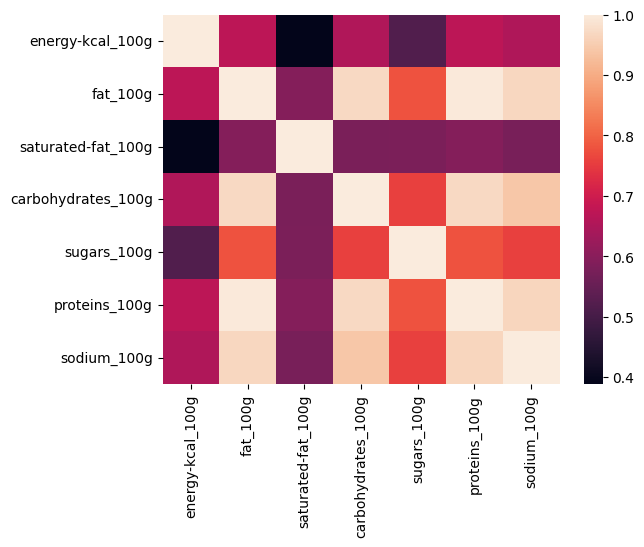

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
miss = df_proc.isna().astype(int)
miss_corr = miss.iloc[:, :7].corr()
sns.heatmap(miss_corr)


<Axes: >

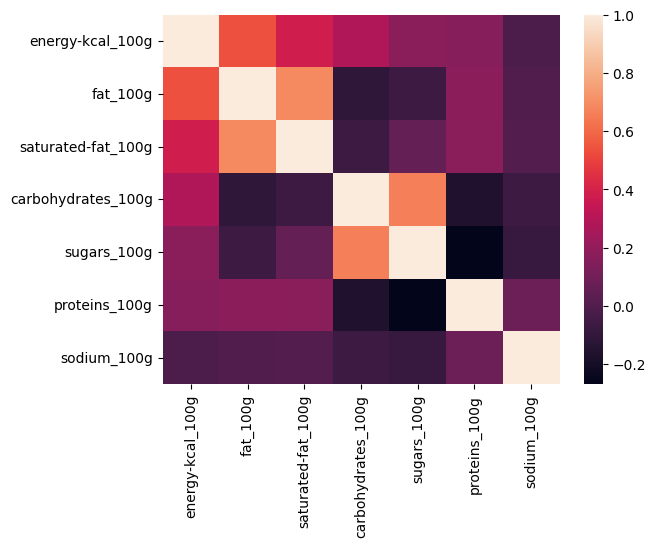

In [23]:
corr = df_proc.iloc[:,:7].corr()
sns.heatmap(corr)

In [24]:
#save the data to s3 bucket
df_proc.to_parquet(f"s3://nutrisage-processed-352364310453/clean_sample/{date}/clean_processed.parquet")